<a href="https://colab.research.google.com/github/greg881203/-/blob/main/people.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

顶层组： ['density']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
data shape (1080, 1920)


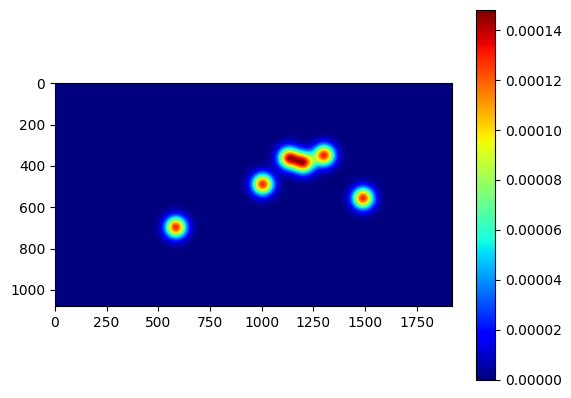

Original Count :  6.0
(68, 120)
resize Original Count :  6.0


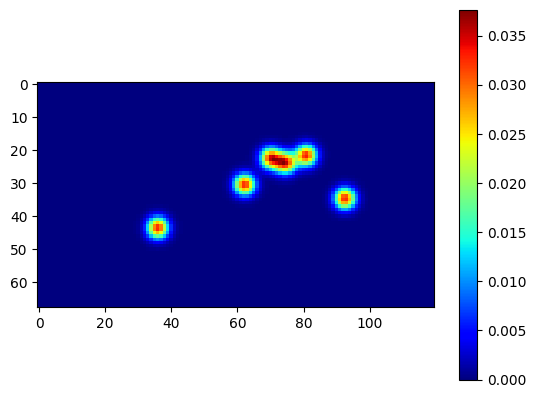

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import h5py
h5_file = h5py.File('1.h5', 'r')
top_level_groups = list(h5_file.keys())
print("顶层组：", top_level_groups)
dataset = h5_file['density']
data = dataset[:]
print(data)
print(f"data shape {data.shape}")
data_array = np.array(data)

# 逐行打印数组
# for row in data_array:
#     print(row)

# 使用matplotlib显示数组
plt.imshow(data_array, cmap=cm.jet)  # 使用 'viridis' 颜色映射
plt.colorbar()  # 显示颜色条
plt.show()
# For showing ground truth

ground_truth_density_map = h5py.File('1.h5', 'r')
ground_truth_density_map = np.asarray(ground_truth_density_map['density'])
resized_ground_truth = cv2.resize(ground_truth_density_map, (120, 68),interpolation=cv2.INTER_CUBIC)* (16**2)

print("Original Count : ", np.around(np.sum(ground_truth_density_map)))
print(resized_ground_truth.shape)

print("resize Original Count : ", np.around(np.sum(resized_ground_truth)))
plt.imshow(resized_ground_truth, cmap=cm.jet)  # 使用 'viridis' 颜色映射
plt.colorbar()  # 显示颜色条
plt.show()

In [ ]:
import h5py
from skimage.io import imread
import os
import cv2
import tensorflow as tf
import numpy as np
imgs = []
ground_truths = []
file = os.listdir('people_images/images')
gt = os.listdir('people_images/grounthtruth')

for i in range(len(file)):
  img_path = f'people_images/images/{file[i]}'
  img = imread(img_path)
#   img = np.expand_dims(img, axis=0)
  imgs.append(img)

  gt_path = f'people_images/grounthtruth/{gt[i]}'
  h5_file = h5py.File(gt_path, 'r')
  ground_truth = np.array(h5_file['density'])
  resized_ground_truth = cv2.resize(ground_truth, (120, 68),interpolation=cv2.INTER_CUBIC)* (16**2)
  ground_truths.append(resized_ground_truth)


# imgs = np.concatenate(imgs, axis=0)
# print(imgs.shape)
imgs = np.array(imgs, dtype=np.float32) / 255.0
dataset = tf.data.Dataset.from_tensor_slices((imgs, ground_truths))
print(dataset)
train_dataset = dataset.batch(1)
print(train_dataset)

<_TensorSliceDataset element_spec=(TensorSpec(shape=(1080, 1920, 3), dtype=tf.float32, name=None), TensorSpec(shape=(68, 120), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 1080, 1920, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 68, 120), dtype=tf.float32, name=None))>


In [ ]:
# 總體結構
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
# 圖像輸入
img_input = Input(shape=(1080, 1920, 3))

# 使用MobileNetV2作為特徵提取層
mobilenetv2 = MobileNetV2(include_top=False, weights='imagenet', input_tensor=img_input)

x = mobilenetv2.layers[115].output
# x = mobilenetv2.layers[115].output
# 10753
x = Conv2D(filters=96, kernel_size=3, strides=(1, 1), padding="same", dilation_rate=1,groups=96,activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, strides=(1, 1), padding="same", dilation_rate=1, groups=96,activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, strides=(1, 1), padding="same", dilation_rate=1, groups=192,activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, strides=(1, 1), padding="same", dilation_rate=1, groups=192,activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, strides=(1, 1), padding="same", dilation_rate=1, groups=192,activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, strides=(1, 1), padding="same", dilation_rate=1, groups=192,activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, strides=(1, 1), padding="same", dilation_rate=1, groups=192,activation='relu')(x)

# 最後輸出density map
density_map = Conv2D(filters=1, kernel_size=1, name='density_map')(x)

# 建立模型
model = Model(img_input, density_map)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1080, 1920, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 540, 960, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 540, 960, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 540, 960, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_dataset, batch_size=1,verbose=1,epochs=30)

Epoch 1/30
100/100 [==============================] - 47s 148ms/step - loss: 1.7522e-05
Epoch 2/30
100/100 [==============================] - 14s 144ms/step - loss: 1.6722e-05
Epoch 3/30
100/100 [==============================] - 15s 145ms/step - loss: 1.6730e-05
Epoch 4/30
100/100 [==============================] - 14s 144ms/step - loss: 1.6735e-05
Epoch 5/30
100/100 [==============================] - 14s 144ms/step - loss: 1.6734e-05
Epoch 6/30
100/100 [==============================] - 14s 145ms/step - loss: 1.6733e-05
Epoch 7/30
100/100 [==============================] - 14s 144ms/step - loss: 1.6735e-05
Epoch 8/30
100/100 [==============================] - 14s 144ms/step - loss: 1.6740e-05
Epoch 9/30
100/100 [==============================] - 15s 145ms/step - loss: 1.6744e-05
Epoch 10/30
100/100 [==============================] - 16s 165ms/step - loss: 1.6747e-05
Epoch 11/30
100/100 [==============================] - 16s 155ms/step - loss: 1.6748e-05
Epoch 12/30
100/100 [=========

In [ ]:
!nvidia-smi

Sat Oct 28 09:56:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

1/1 [==============================] - 0s 52ms/step
預測: [[[[0.00080636]
   [0.00080636]
   [0.00080636]
   ...
   [0.00080636]
   [0.00080636]
   [0.00080636]]

  [[0.00080636]
   [0.00080636]
   [0.00080636]
   ...
   [0.00080636]
   [0.00080636]
   [0.00080636]]

  [[0.00080636]
   [0.00080636]
   [0.00080636]
   ...
   [0.00080636]
   [0.00080636]
   [0.00080636]]

  ...

  [[0.00080636]
   [0.00080636]
   [0.00080636]
   ...
   [0.00080636]
   [0.00080636]
   [0.00080636]]

  [[0.00080636]
   [0.00080636]
   [0.00080636]
   ...
   [0.00080636]
   [0.00080636]
   [0.00080636]]

  [[0.00080636]
   [0.00080636]
   [0.00080636]
   ...
   [0.00080636]
   [0.00080636]
   [0.00080636]]]]
預測 shape : (1, 68, 120, 1)
預測 density_map squeeze shape : (68, 120)


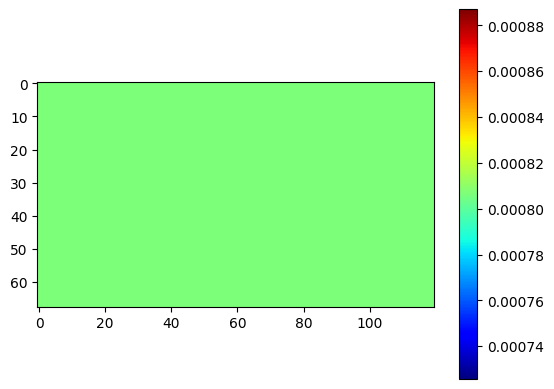

In [ ]:
# 載入圖像
from tensorflow.keras.preprocessing import image
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
img_path = '1.jpg'
# 輸入圖像
image = Image.open(img_path)  # 使用 Pillow 開啟圖像

# 將圖像轉換為 NumPy 陣列
image_np = np.array(image)

# 正規化圖像到 [0, 1] 範圍
image_normalized = image_np / 255.0

# 執行預測
density_map = model.predict(np.expand_dims(image_normalized, axis=0))

print("預測:", density_map)
print("預測 shape :", density_map.shape)
# # 創建密度圖

density_map = density_map.squeeze()  # 這裡替換為你的密度圖

print("預測 density_map squeeze shape :", density_map.shape)
# 繪製等高線圖
plt.imshow(density_map, cmap=cm.jet)
plt.colorbar()
plt.show()